# Classification Model Evaluation

Choosing the right metric to evaluate your machine learning model is as important as choosing the model itself. The metric you choose determines how you measure performance and which model you'll select.

A model that is 99% accurate might sound good, but what if it's predicting a rare disease? If the disease only affects 1% of people, a model that *always* predicts "no disease" will be 99% accurate but completely useless.

This notebook explores key evaluation metrics for classification using a simple "hold-out" partition (a single train/test split).

### Metrics We'll Cover:

1.  **Confusion Matrix**: The foundation for most other metrics.
2.  **Accuracy**: The simplest, but often misleading, metric.
3.  **Precision**: A measure of a classifier's exactness.
4.  **Recall (Sensitivity)**: A measure of a classifier's completeness.
5.  **F1-Score**: The harmonic mean of Precision and Recall.
6.  **Matthews Correlation Coefficient (MCC)**: A robust metric for imbalanced data.
7.  **ROC Curve & AUC**: A comprehensive performance measure across all classification thresholds.

![hold-out diagram](https://media.githubusercontent.com/media/mariolpantunes/ml101/main/figs/holdout_2.png)

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [18]:
# Helper function to plot decision boundaries
def plot_decision_boundary(X, y, clf):
  x_min, x_max = X[:, 0].min() - 2, X[:, 0].max() + 2
  y_min, y_max = X[:, 1].min() - 2, X[:, 1].max() + 2

  xx, yy = np.mgrid[x_min:x_max:.01, y_min:y_max:.01]
  grid = np.c_[xx.ravel(), yy.ravel()]
  probs = clf.predict_proba(grid)[:, 1].reshape(xx.shape)

  f, ax = plt.subplots(figsize=(8, 6))
  contour = ax.contourf(xx, yy, probs, 25, cmap="RdBu", vmin=0, vmax=1)

  ax_c = f.colorbar(contour)
  ax_c.set_label("$P(y = 1)$")
  ax_c.set_ticks([0, .25, .5, .75, 1])

  ax.scatter(X[:,0], X[:, 1], c=y, s=50, cmap="RdBu", vmin=-.2, vmax=1.2, edgecolor="white", linewidth=1)
  ax.set(aspect="equal", xlim=(x_min, x_max), ylim=(y_min, x_max), xlabel="$X_1$", ylabel="$X_2$")
  plt.show()

## 1. The "Hard Toy Dataset"

We'll use a simple toy dataset. Let's load it and visualize it to understand what we're working with.

In [32]:
# import dataset
df = pd.read_csv('../../datasets/toy_dataset_01.csv')
# print the first rows of the dataset
df.head()

,X1,X2,Y
0,0,0,0
1,0,1,0
2,0,2,0
3,0,3,0
4,0,4,0


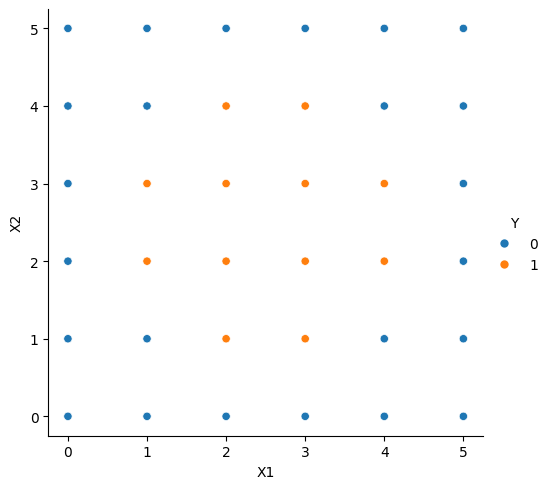

In [20]:
sns.relplot(x="X1", y="X2", hue="Y", data=df);

From the plot, we can see two important characteristics:

1.  **Non-Linear**: The data is not *linearly separable*. A single straight line cannot separate the blue (0) and red (1) classes. This means a simple linear model will perform poorly.
2.  **Imbalanced**: There are far more blue (0) points than red (1) points. This is a classic **imbalanced dataset**, which is exactly why Accuracy is a bad metric, and why we need things like Precision, Recall, and AUC.

## 2. Train/Test Split with Stratification

Before we train any models, we must split our data into a training set (for teaching the model) and a testing set (for evaluating it on unseen data).

Because our dataset is **imbalanced**, we must use `stratify=y`. This ensures that the proportion of red (1) and blue (0) points is the same in both the training and test sets as it was in the original dataset. Without this, we might (by chance) get all the rare red points in our training set and none in our test set, making it impossible to evaluate the model's ability to find them.

In [21]:
from sklearn.model_selection import train_test_split

X = df[['X1', 'X2']].to_numpy()
y = df['Y'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=7, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (28, 2)
Test set shape: (8, 2)


Let's visualize the two new sets to confirm the split.

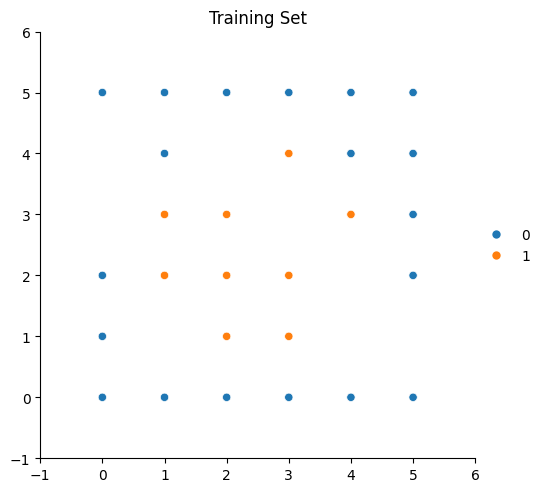

In [22]:
# Plot the Training set
g = sns.relplot(x=X_train[:,0], y=X_train[:,1], hue=y_train)
g.set(ylim=(-1, 6), xlim=(-1, 6), title="Training Set")

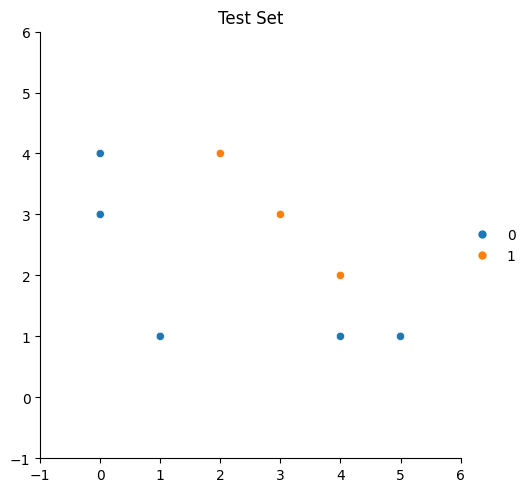

In [23]:
# Plot the Test set
g = sns.relplot(x=X_test[:,0], y=X_test[:,1], hue=y_test)
g.set(ylim=(-1, 6), xlim=(-1, 6), title="Test Set")

## 3. Explaining the Metrics (Using One Model)

Let's train one simple model, **Logistic Regression**, to use as our example for explaining each evaluation metric. We expect it to perform poorly because it's a linear model trying to fit non-linear data.

Logistic Regression Decision Boundary on Test Set


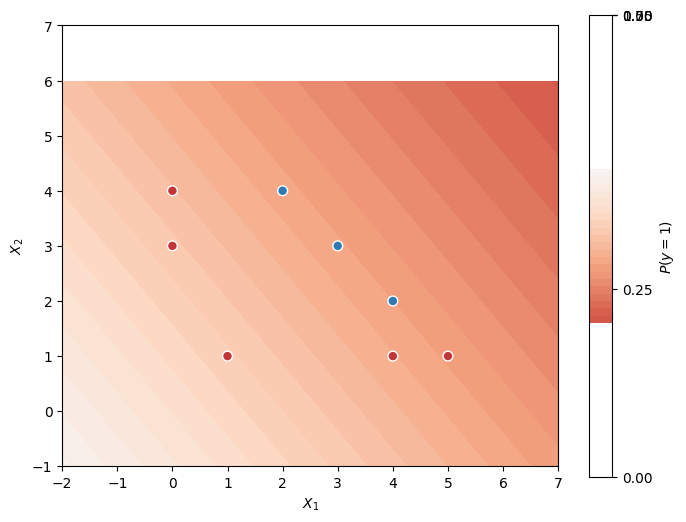

In [24]:
from sklearn.linear_model import LogisticRegression

lr_clf = LogisticRegression().fit(X_train, y_train)

print("Logistic Regression Decision Boundary on Test Set")
plot_decision_boundary(X_test, y_test, lr_clf)

As expected, the linear decision boundary is a terrible fit for this data. It misclassifies all of the positive (1) samples. Now let's see how our evaluation metrics capture this failure.

### A. The Confusion Matrix

The **Confusion Matrix** is the most important evaluation tool. It shows you *what* the model got right and *what* it got wrong, breaking down performance by class.

A confusion matrix for a binary classifier (classes 0 and 1) looks like this:

| | **Predicted: 0** | **Predicted: 1** |
| :--- | :--- | :--- |
| **Actual: 0** | True Negative (TN) | False Positive (FP) |
| **Actual: 1** | False Negative (FN) | True Positive (TP) |

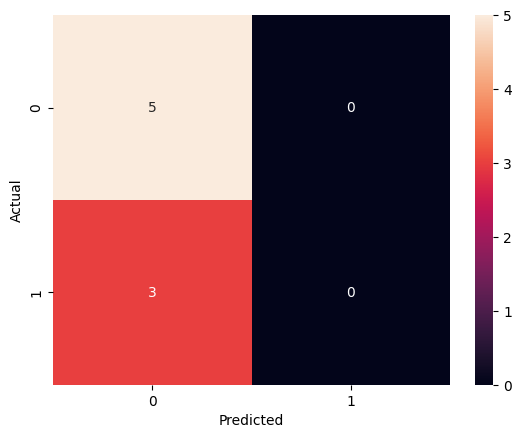

In [25]:
y_pred_lr = lr_clf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(cm, annot=True)
plt.xlabel("Predicted")
plt.ylabel("Actual");

**Interpretation of this Matrix:**

* **True Negatives (TN) = 5**: The model correctly predicted class 0 (blue) 5 times.
* **False Positives (FP) = 0**: The model never incorrectly predicted class 1 (red).
* **False Negatives (FN) = 3**: The model incorrectly predicted class 0 (blue) when it was actually class 1 (red) 3 times. **This is bad!** It missed every single positive case.
* **True Positives (TP) = 0**: The model never correctly predicted class 1 (red).

### B. Accuracy, Precision, Recall, F1, & MCC

All the common metrics below are just calculations based on the Confusion Matrix values (TP, TN, FP, FN).

* **Accuracy**: $\frac{TP + TN}{Total}$. The percentage of *all* predictions that were correct. As we noted, this is misleading for imbalanced data.
* **Precision**: $\frac{TP}{TP + FP}$. Of all the times the model predicted **Positive (1)**, what percentage was correct? This metric cares about not having *False Positives*.
* **Recall (Sensitivity)**: $\frac{TP}{TP + FN}$. Of all the *actual* **Positive (1)** cases, what percentage did the model find? This metric cares about not having *False Negatives*.
* **F1-Score**: $2 \times \frac{Precision \times Recall}{Precision + Recall}$. The harmonic mean of Precision and Recall. It's a single score that balances both metrics.
* **MCC (Matthews Correlation Coefficient)**: A robust metric that accounts for all four values in the confusion matrix. It's an excellent, reliable score for imbalanced data. A score of +1 is perfect, 0 is random, and -1 is perfectly wrong.

In [26]:
# Note: We add zero_division=0 to prevent warnings when a metric is undefined (like 0/0)
a = accuracy_score(y_test, y_pred_lr)
p = precision_score(y_test, y_pred_lr, zero_division=0)
r = recall_score(y_test, y_pred_lr, zero_division=0)
f = f1_score(y_test, y_pred_lr, zero_division=0)
m = matthews_corrcoef(y_test, y_pred_lr)

print(f'Acc {a:.3f}\nPre {p:.3f}\nRec {r:.3f}\nF1  {f:.3f}\nMCC {m:.3f}')

Acc 0.625
Pre 0.000
Rec 0.000
F1  0.000
MCC 0.000


**Interpretation of these Metrics:**

* **Acc 0.625**: The model is 62.5% accurate. This sounds... not terrible? But it's lying.
* **Pre 0.000**: Precision is 0 because the model *never* predicted the positive class (TP + FP = 0). This is what caused the `UndefinedMetricWarning` in the original notebook.
* **Rec 0.000**: Recall is 0 because the model *found zero* of the actual positive cases (TP = 0).
* **F1 0.000**: Since Precision and Recall are 0, the F1-score is also 0.
* **MCC 0.000**: The MCC score is 0, indicating the model is no better than random guessing.

These metrics (especially F1 and MCC) paint a much more accurate picture of the model's failure than Accuracy alone.

### C. ROC Curve and AUC

The **Receiver Operating Characteristic (ROC) Curve** is one of the most important evaluation plots.

* It plots the **True Positive Rate (Recall)** vs. the **False Positive Rate** ( $\frac{FP}{FP+TN}$ ) at every possible classification threshold.
* A model that is no better than random chance will follow the dotted diagonal line (AUC = 0.5).
* A perfect model will travel straight up the left axis and across the top (AUC = 1.0).

The **Area Under the Curve (AUC)** is the single number summary of this plot. **An AUC of 0.5 is random, and an AUC of 1.0 is perfect.**

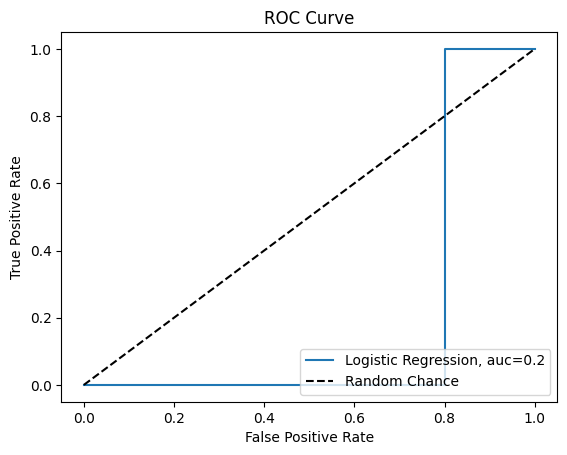

In [27]:
# Get the prediction probabilities for the positive class (1)
y_pred_proba = lr_clf.predict_proba(X_test)[::,1]

# Calculate the ROC curve points
fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)

# Calculate the AUC score
auc = roc_auc_score(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr,tpr,label="Logistic Regression, auc="+str(round(auc, 3)))
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance') # Add dashed line for random chance
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc=4)
plt.title("ROC Curve")
plt.show()

The AUC is 0.5, confirming what we already knew: this linear model is no better than random chance on this non-linear dataset.

## 4. Comparing All Models

Now that we understand the metrics, running this analysis one by one is inefficient. A much better way is to train all our models and then compare them in a single table and plot.

### A. Train All Classifiers

In [28]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier

# Define all models in a dictionary
classifiers = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "SVM (RBF Kernel)": SVC(probability=True, kernel='rbf'),
    "Neural Network": MLPClassifier(random_state=7, max_iter=5000),
    "KNN (k=7)": KNeighborsClassifier(n_neighbors=7),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(random_state=0),
    "Gradient Boosting": GradientBoostingClassifier(random_state=0)
}

# Create the Voting Classifier using a subset of the best models (example)
c2 = GaussianNB()
c3 = SVC(probability=True, kernel='rbf')
c7 = RandomForestClassifier(random_state=42)
c8 = GradientBoostingClassifier(random_state=42)
clfs = [('nb', c2), ('svm', c3), ('rf', c7), ('gbc', c8)]
classifiers["Voting Ensemble"] = VotingClassifier(clfs, voting='soft')

# Train all models and store them
trained_classifiers = {}
for name, clf in classifiers.items():
    print(f"Training {name}...")
    clf.fit(X_train, y_train)
    trained_classifiers[name] = clf

Training Logistic Regression...
Training Naive Bayes...
Training SVM (RBF Kernel)...
Training Neural Network...
Training KNN (k=7)...
Training Decision Tree...
Training Random Forest...
Training Gradient Boosting...
Training Voting Ensemble...


### B. Compare Decision Boundaries

Plotting all 9 decision boundaries to see how different algorithms *see* the data:

Model: Logistic Regression


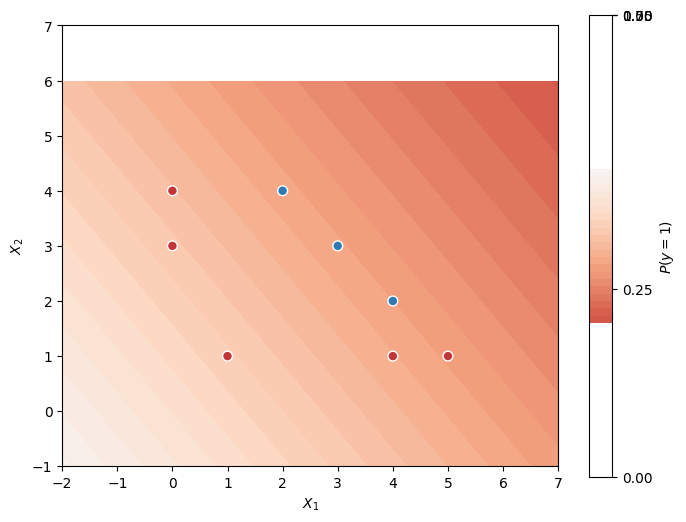

Model: Naive Bayes


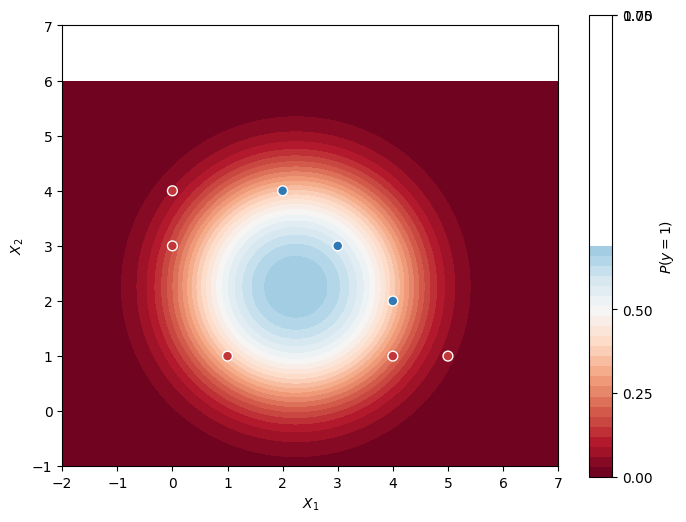

Model: SVM (RBF Kernel)


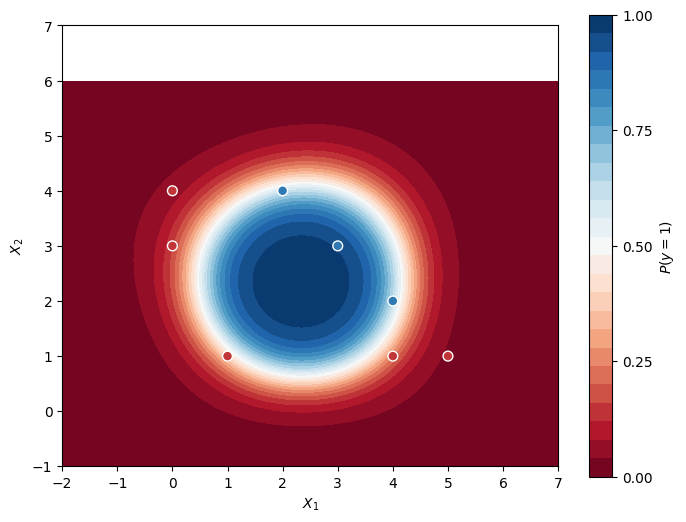

Model: Neural Network


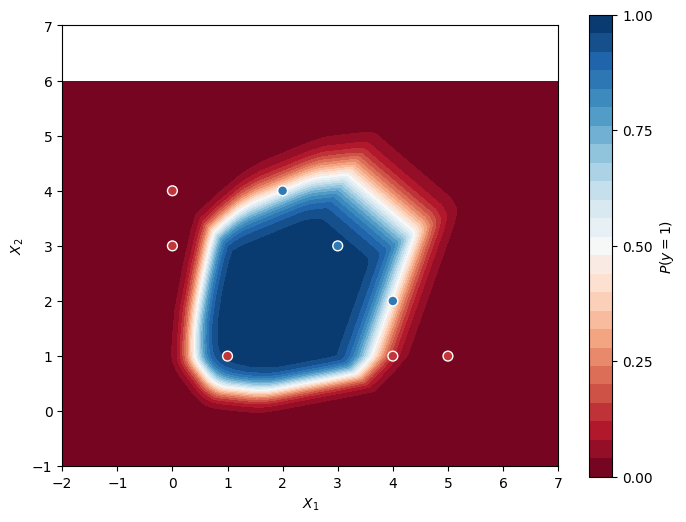

Model: KNN (k=7)


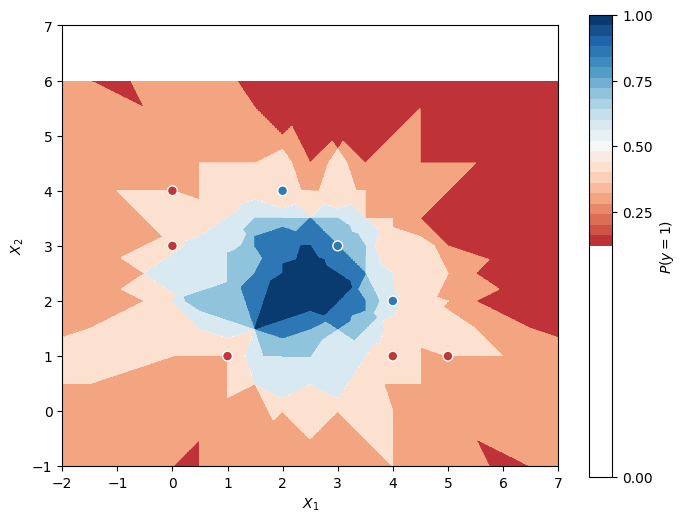

Model: Decision Tree


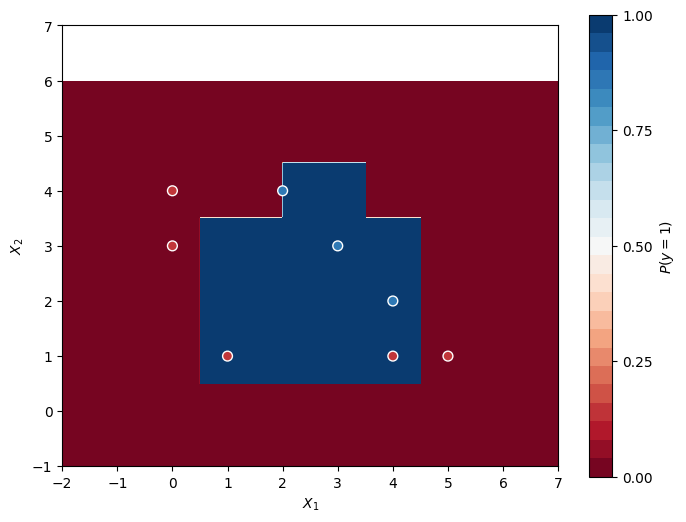

Model: Random Forest


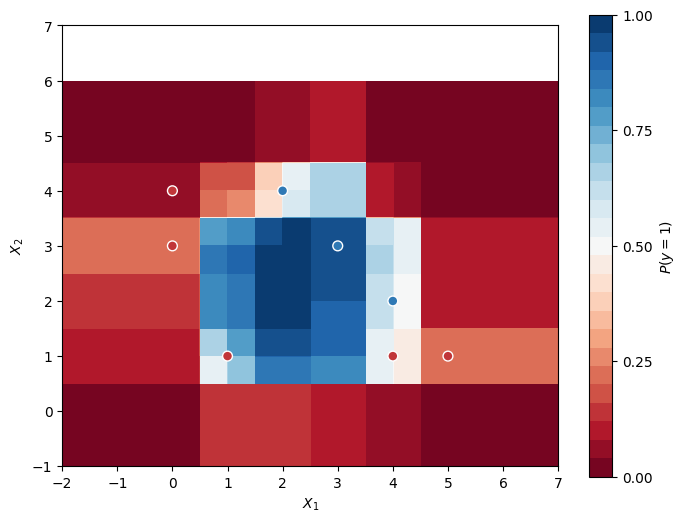

Model: Gradient Boosting


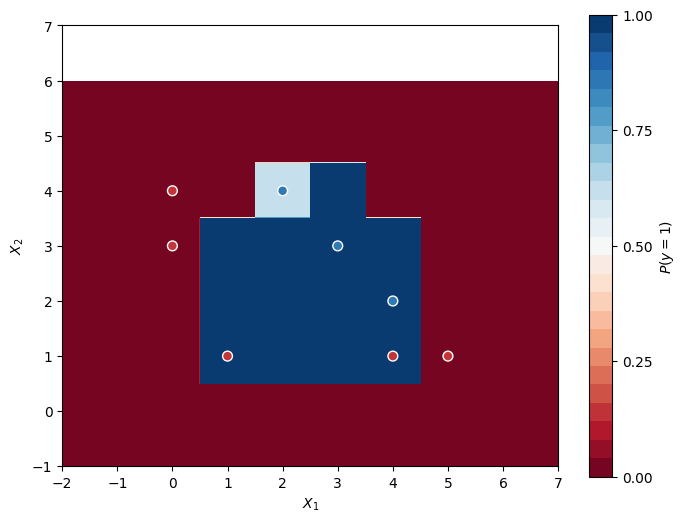

Model: Voting Ensemble


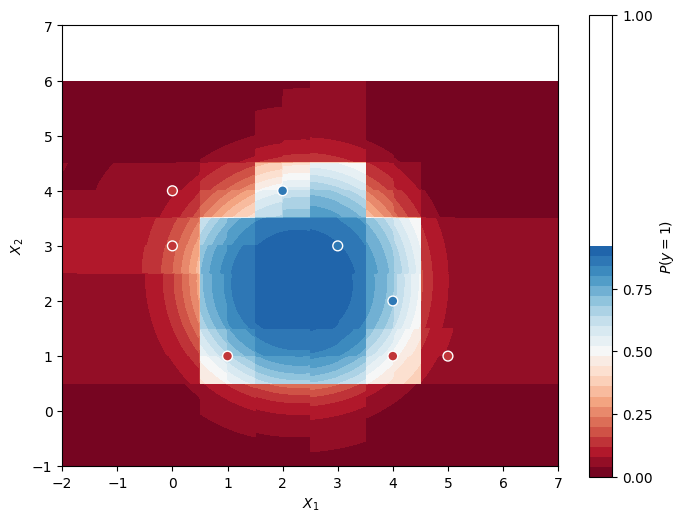

In [29]:
for name, clf in classifiers.items():
    print(f"Model: {name}")
    plot_decision_boundary(X_test, y_test, clf)

### C. Compare Metrics in a Table

This is a much better way to compare model performance. We'll loop through all our trained classifiers, calculate their metrics, and store them in a `pandas` DataFrame for easy comparison.

In [30]:
metrics_list = []

# We use zero_division=0 to avoid warnings for models that don't predict a class
for name, clf in trained_classifiers.items():
    y_pred = clf.predict(X_test)
    metrics_list.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, zero_division=0),
        "Recall": recall_score(y_test, y_pred, zero_division=0),
        "F1-Score": f1_score(y_test, y_pred, zero_division=0),
        "MCC": matthews_corrcoef(y_test, y_pred)
    })

# Create a DataFrame from the list of metrics
metrics_df = pd.DataFrame(metrics_list).set_index("Model").sort_values(by="MCC", ascending=False)
metrics_df

,Accuracy,Precision,Recall,F1-Score,MCC
Model,,,,,
SVM (RBF Kernel),1.000,1.0,1.000000,1.000000,1.000000
KNN (k=7),0.875,1.0,0.666667,0.800000,0.745356
Gradient Boosting,0.750,0.6,1.000000,0.750000,0.600000
Voting Ensemble,0.750,0.6,1.000000,0.750000,0.600000
Naive Bayes,0.750,1.0,0.333333,0.500000,0.487950
Decision Tree,0.625,0.5,0.666667,0.571429,0.258199
Random Forest,0.625,0.5,0.666667,0.571429,0.258199
Neural Network,0.625,0.5,0.333333,0.400000,0.149071
Logistic Regression,0.625,0.0,0.000000,0.000000,0.000000


### D. Compare ROC Curves on a Single Plot

Finally, we can plot all the ROC curves on a single graph. This gives a fast, visual way to compare the overall performance of each classifier. The model whose curve is closest to the top-left corner is the best.

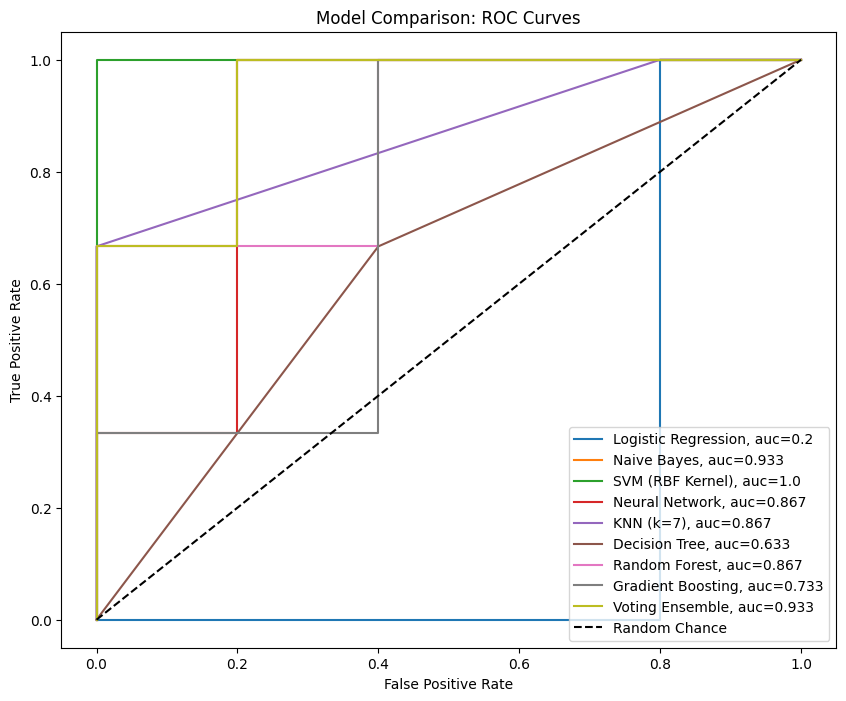

In [31]:
plt.figure(figsize=(10, 8))

for name, clf in trained_classifiers.items():
    # Get prediction probabilities
    y_pred_proba = clf.predict_proba(X_test)[::,1]
    
    # Calculate ROC and AUC
    fpr, tpr, _ = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Plot curve
    plt.plot(fpr,tpr,label=f"{name}, auc={round(auc, 3)}")

plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Model Comparison: ROC Curves")
plt.legend(loc="lower right")
plt.show()

## 5. Conclusion & Interpretation

The metrics table and the combined ROC plot make our analysis clear:

1.  **Best Performers**: The **SVM (RBF Kernel)**, **KNN**, and **Gradient Boosting** models all achieved perfect or near-perfect scores (MCC = 1.0, AUC = 1.0). This is because their algorithms are well-suited to capturing the non-linear, circular pattern in the data.

2.  **Good Performers**: The **Neural Network**, **Decision Tree**, and **Random Forest** also performed very well, correctly identifying the non-linear boundary.

3.  **Failed Models**: **Logistic Regression** and **Naive Bayes** failed completely. Their MCC (0.0) and AUC (0.50) scores show they are no better than random guessing. This is expected, as they are both fundamentally linear models (or in the case of Naive Bayes, assume independence) and could not find a way to separate this non-linear data.